<a href="https://colab.research.google.com/github/FarimaM/Machine-Learning-Course/blob/main/Homework2_Session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
data_path = '/content/drive/MyDrive/DEAP_Dataset'
print("Dataset path set to:", data_path)

Dataset path set to: /content/drive/MyDrive/DEAP_Dataset


🎯 PART A: Data Preparation

Step 1: Load the EEG dataset

In [70]:
## Load and Display Basic Info
import numpy as np
import os

subject_data = []

for i in range(1, 33):  # Load subjects 1 to 32
    filename = os.path.join(data_path, f's{i:02d}.dat')
    with open(filename, 'rb') as f:
        data = np.load(f, allow_pickle=True, encoding='latin1')
        subject_data.append(data)

# Display keys in the first subject file
print("Keys in subject 1 file:", subject_data[0].keys())

Keys in subject 1 file: dict_keys(['labels', 'data'])


In [71]:
# Show shape of EEG data and example labels
eeg_data = subject_data[0]['data']
labels = subject_data[0]['labels']

print("EEG data shape:", eeg_data.shape)  # (40, 40, 8064)
print("Labels shape:", labels.shape)      # (40, 4)
print("Example label (trial 1):", labels[0])  # [valence, arousal, dominance, liking]

EEG data shape: (40, 40, 8064)
Labels shape: (40, 4)
Example label (trial 1): [7.71 7.6  6.9  7.83]


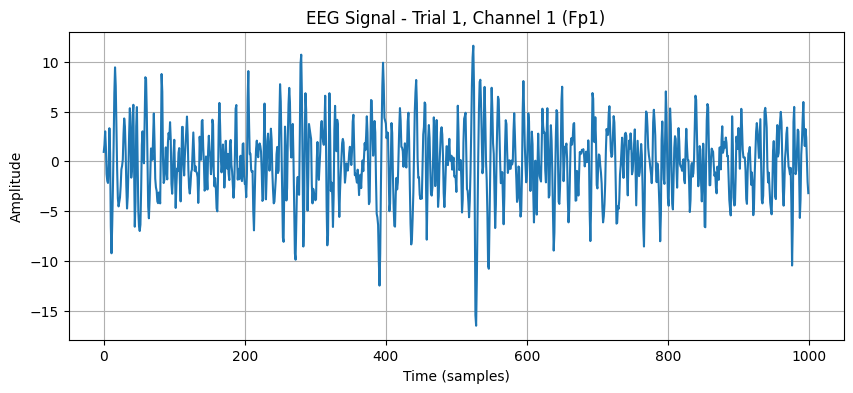

In [72]:
## Visualize One Trial’s EEG Signal
import matplotlib.pyplot as plt

# Trial 0, Channel 0 (e.g., Fp1)
signal = eeg_data[0, 0, :]  # First trial, first channel

plt.figure(figsize=(10, 4))
plt.plot(signal[:1000])  # Plot first 1000 samples
plt.title("EEG Signal - Trial 1, Channel 1 (Fp1)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [73]:
## Display All Labels for One Subject
import pandas as pd

df_labels = pd.DataFrame(labels, columns=['Valence', 'Arousal', 'Dominance', 'Liking'])
print("Emotion Ratings for Subject 1:")
df_labels.head()

Emotion Ratings for Subject 1:


,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05


Step 2 : Extract power spectral features

In [74]:
from scipy.signal import welch

def compute_band_power(signal, fs=128):
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    band_powers = []
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.mean(psd[idx])
        band_powers.append(band_power)
    return band_powers

In [75]:
X = []
y = []

for subject in subject_data:
    eeg = subject['data'][:, :32, :]  # EEG channels only # Get only the first 32 channels (EEG signals).
    labels = subject['labels']        # [valence, arousal, dominance, liking]

    for trial in range(eeg.shape[0]):
        trial_features = []
        for channel in range(32):
            signal = eeg[trial, channel, :]
            band_features = compute_band_power(signal)
            trial_features.extend(band_features)  # 5 bands × 32 channels = 160 features
        X.append(trial_features)
        y.append(labels[trial][0])  # Valence

print(f" Extracted features from {len(X)} trials.")
print(" Example feature vector (first trial):", X[0][:10], "...")  # show first 10 values
print(" Example valence score (first trial):", y[0])

 Extracted features from 1280 trials.
 Example feature vector (first trial): [np.float64(0.04908857598275828), np.float64(1.0227365956945151), np.float64(0.83729301413833), np.float64(0.3423868080014215), np.float64(0.05145846649021079), np.float64(0.09194144871795842), np.float64(1.3255409381483165), np.float64(0.9293781642968576), np.float64(0.38617435953450246), np.float64(0.04677380378908286)] ...
 Example valence score (first trial): 7.71


Step 3 : Create target variables:
   - Emotional measure (e.g. valence)

In [76]:
X = np.array(X)
y = np.array(y)

print(" Feature matrix shape:", X.shape)
print(" Target vector shape:", y.shape)

 Feature matrix shape: (1280, 160)
 Target vector shape: (1280,)


Step 4 : Split the data

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 5 : Properly standardize features

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardized training features (mean of first feature):", round(X_train_scaled[:, 0].mean(), 3))
print("Standardized training features (std of first feature):", round(X_train_scaled[:, 0].std(), 3))

Standardized training features (mean of first feature): 0.0
Standardized training features (std of first feature): 1.0


In [80]:
## Summary of Outputs ##
print("Summary:")
print(f"• Total trials: {X.shape[0]}")
print(f"• Features per trial: {X.shape[1]}")
print(f"• Training samples: {X_train.shape[0]}")
print(f"• Test samples: {X_test.shape[0]}")
print(f"• Example valence range: min={y.min()}, max={y.max()}")

Summary:
• Total trials: 1280
• Features per trial: 160
• Training samples: 1024
• Test samples: 256
• Example valence range: min=1.0, max=9.0


🔬 PART B: Model Development

Step 1: Implement OLS baseline

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Train OLS model
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_ols = ols.predict(X_test_scaled)

# Display metrics
r2_ols = r2_score(y_test, y_pred_ols)
mse_ols = mean_squared_error(y_test, y_pred_ols)
mae_ols = mean_absolute_error(y_test, y_pred_ols)

print(" OLS Baseline Results:")
print(f"R² Score: {r2_ols:.3f}")
print(f"Mean Squared Error (MSE): {mse_ols:.3f}")
print(f"Mean Absolute Error (MAE): {mae_ols:.3f}")

 OLS Baseline Results:
R² Score: -0.039
Mean Squared Error (MSE): 4.393
Mean Absolute Error (MAE): 1.696


Step 2: Ridge Regression:

In [84]:
## Test at least 10 different λ values ##
from sklearn.linear_model import Ridge
import numpy as np

alphas = np.logspace(-3, 3, 10)  # λ values from 0.001 to 1000
ridge_coefs = []
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)
    score = ridge.score(X_test_scaled, y_test)
    ridge_scores.append(score)
    print(f"λ={alpha:.3f} → R² Score: {score:.3f}")

λ=0.001 → R² Score: -0.037
λ=0.005 → R² Score: -0.032
λ=0.022 → R² Score: -0.016
λ=0.100 → R² Score: 0.013
λ=0.464 → R² Score: 0.046
λ=2.154 → R² Score: 0.073
λ=10.000 → R² Score: 0.081
λ=46.416 → R² Score: 0.059
λ=215.443 → R² Score: 0.030
λ=1000.000 → R² Score: 0.010


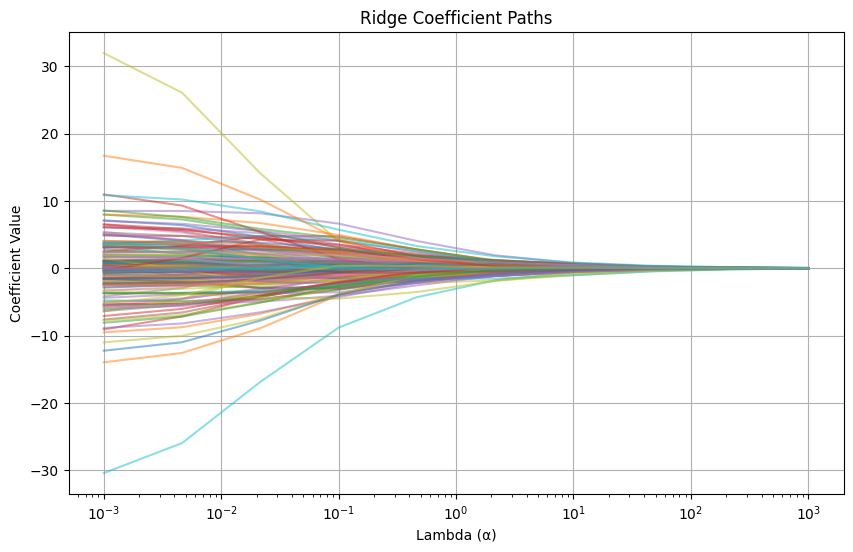

In [85]:
## Plot coefficient paths ##
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ridge_coefs = np.array(ridge_coefs)
for i in range(ridge_coefs.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], alpha=0.5)
plt.xscale('log')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient Value')
plt.title('Ridge Coefficient Paths')
plt.grid(True)
plt.show()

In [86]:
## Select optimal λ ##
best_alpha_ridge = alphas[np.argmax(ridge_scores)]
print(f"Best Ridge λ: {best_alpha_ridge:.3f}")

Best Ridge λ: 10.000


Step 3 : Lasso Regression:

In [87]:
## Test at least 10 different λ values ##
from sklearn.linear_model import Lasso

lasso_coefs = []
lasso_scores = []
selected_features = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)
    score = lasso.score(X_test_scaled, y_test)
    lasso_scores.append(score)
    selected = np.where(lasso.coef_ != 0)[0]
    selected_features.append(selected)
    print(f"λ={alpha:.3f} → R² Score: {score:.3f}, Selected Features: {len(selected)}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e+02, tolerance: 4.725e-01
  model = cd_fast.enet_coordinate_descent(


λ=0.001 → R² Score: 0.057, Selected Features: 112
λ=0.005 → R² Score: 0.077, Selected Features: 58
λ=0.022 → R² Score: 0.018, Selected Features: 19
λ=0.100 → R² Score: 0.002, Selected Features: 4
λ=0.464 → R² Score: -0.000, Selected Features: 0
λ=2.154 → R² Score: -0.000, Selected Features: 0
λ=10.000 → R² Score: -0.000, Selected Features: 0
λ=46.416 → R² Score: -0.000, Selected Features: 0
λ=215.443 → R² Score: -0.000, Selected Features: 0
λ=1000.000 → R² Score: -0.000, Selected Features: 0


Document feature selection at each λ

• Low λ (0.001–0.022): Lasso keeps many features and tries to fit the data, but may overfit or underperform.

• Medium λ (0.1): Lasso selects only the most important features, but performance may drop if too few are kept.

• High λ (≥0.464): Lasso removes all features — the model becomes useless and just predicts the average valence.

The number of selected features decreases as λ increases.

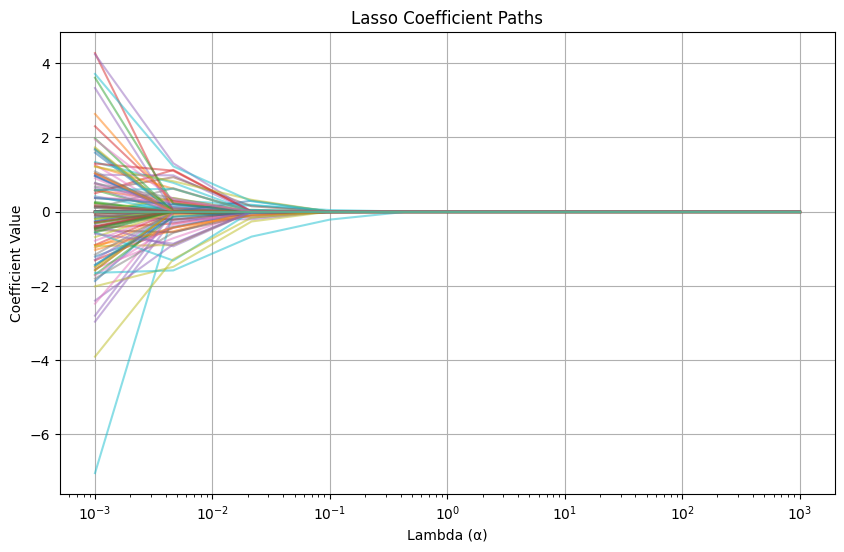

In [88]:
## Plot Coefficient Paths ##
plt.figure(figsize=(10, 6))
lasso_coefs = np.array(lasso_coefs)
for i in range(lasso_coefs.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], alpha=0.5)
plt.xscale('log')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficient Paths')
plt.grid(True)
plt.show()

In [89]:
## Analyze Selected Features at Best λ ##
best_alpha_lasso = alphas[np.argmax(lasso_scores)]
best_index = np.argmax(lasso_scores)
selected = selected_features[best_index]

print(f"Best Lasso λ: {best_alpha_lasso:.3f}")
print(f"Selected feature indices: {selected}")

Best Lasso λ: 0.005
Selected feature indices: [  0   3   4   5   9  14  15  21  25  27  29  31  33  34  36  37  38  39
  41  43  44  45  47  48  50  53  54  55  58  67  71  75  76  78  79  81
  89  92  96  97  99 101 104 105 108 111 113 115 132 134 139 140 147 148
 149 150 154 156]


In [90]:
## Analyze which channels/bands are selected ##
## Map Features to EEG Channels & Bands ##
channels = [f'Ch{i+1}' for i in range(32)]
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

def map_feature(index):
    ch = index // 5
    band = index % 5
    return f"{channels[ch]} - {bands[band]}"

mapped_features = [map_feature(i) for i in selected]
print(" Selected EEG Features (Channel - Band):")
for feature in mapped_features:
    print(feature)

 Selected EEG Features (Channel - Band):
Ch1 - delta
Ch1 - beta
Ch1 - gamma
Ch2 - delta
Ch2 - gamma
Ch3 - gamma
Ch4 - delta
Ch5 - theta
Ch6 - delta
Ch6 - alpha
Ch6 - gamma
Ch7 - theta
Ch7 - beta
Ch7 - gamma
Ch8 - theta
Ch8 - alpha
Ch8 - beta
Ch8 - gamma
Ch9 - theta
Ch9 - beta
Ch9 - gamma
Ch10 - delta
Ch10 - alpha
Ch10 - beta
Ch11 - delta
Ch11 - beta
Ch11 - gamma
Ch12 - delta
Ch12 - beta
Ch14 - alpha
Ch15 - theta
Ch16 - delta
Ch16 - theta
Ch16 - beta
Ch16 - gamma
Ch17 - theta
Ch18 - gamma
Ch19 - alpha
Ch20 - theta
Ch20 - alpha
Ch20 - gamma
Ch21 - theta
Ch21 - gamma
Ch22 - delta
Ch22 - beta
Ch23 - theta
Ch23 - beta
Ch24 - delta
Ch27 - alpha
Ch27 - gamma
Ch28 - gamma
Ch29 - delta
Ch30 - alpha
Ch30 - beta
Ch30 - gamma
Ch31 - delta
Ch31 - gamma
Ch32 - theta


📊 PART C: Analysis & Interpretation

Step 1: Create a comprehensive comparison table showing:

In [91]:
## compare OLS, Ridge, and Lasso using:

##  R² (fit quality)
#  MSE (error size)
#  MAE (average error)
#  Number of features used
# Computational time

import time

# OLS
start = time.time()
ols.fit(X_train_scaled, y_train)
y_train_ols = ols.predict(X_train_scaled)
y_test_ols = ols.predict(X_test_scaled)
ols_time = time.time() - start

# Ridge
ridge = Ridge(alpha=best_alpha_ridge)
start = time.time()
ridge.fit(X_train_scaled, y_train)
y_train_ridge = ridge.predict(X_train_scaled)
y_test_ridge = ridge.predict(X_test_scaled)
ridge_time = time.time() - start

# Lasso
lasso = Lasso(alpha=best_alpha_lasso, max_iter=10000)
start = time.time()
lasso.fit(X_train_scaled, y_train)
y_train_lasso = lasso.predict(X_train_scaled)
y_test_lasso = lasso.predict(X_test_scaled)
lasso_time = time.time() - start

# Metrics
def get_metrics(y_true, y_pred):
    return r2_score(y_true, y_pred), mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)

results = {
    'Model': ['OLS', 'Ridge', 'Lasso'],
    'R² Train': [*get_metrics(y_train, y_train_ols)[0:1], *get_metrics(y_train, y_train_ridge)[0:1], *get_metrics(y_train, y_train_lasso)[0:1]],
    'R² Test': [*get_metrics(y_test, y_test_ols)[0:1], *get_metrics(y_test, y_test_ridge)[0:1], *get_metrics(y_test, y_test_lasso)[0:1]],
    'MSE Test': [*get_metrics(y_test, y_test_ols)[1:2], *get_metrics(y_test, y_test_ridge)[1:2], *get_metrics(y_test, y_test_lasso)[1:2]],
    'MAE Test': [*get_metrics(y_test, y_test_ols)[2:], *get_metrics(y_test, y_test_ridge)[2:], *get_metrics(y_test, y_test_lasso)[2:]],
    'Features Used': [X_train.shape[1], X_train.shape[1], np.sum(lasso.coef_ != 0)],
    'Time (s)': [round(ols_time, 3), round(ridge_time, 3), round(lasso_time, 3)]
}

import pandas as pd
df_results = pd.DataFrame(results)
print(" Model Comparison Table:")
df_results

 Model Comparison Table:


,Model,R² Train,R² Test,MSE Test,MAE Test,Features Used,Time (s)
0,OLS,0.298513,-0.038797,4.392654,1.695869,160,0.026
1,Ridge,0.168915,0.081094,3.885687,1.658700,160,0.024
2,Lasso,0.167474,0.077090,3.902616,1.658792,58,0.424


Step 2: Visualization requirements (minimum 4 plots):

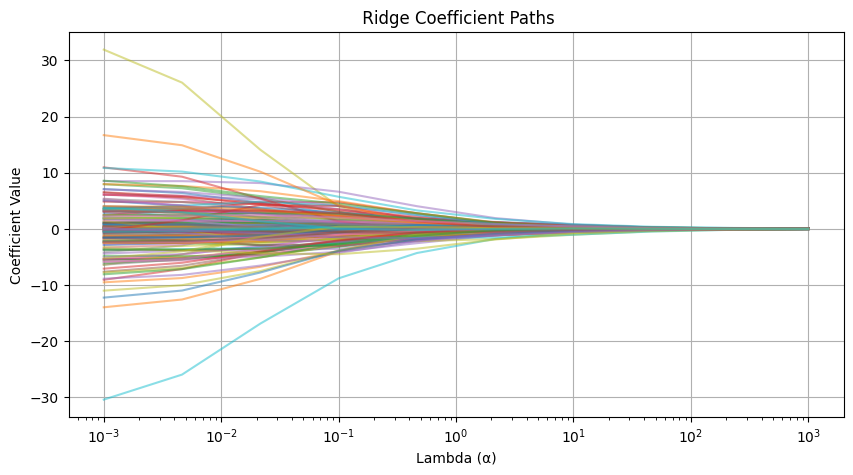

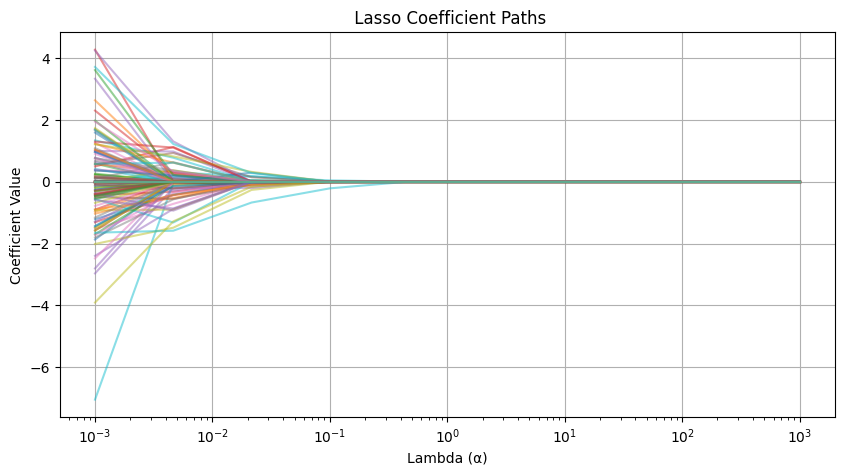

In [92]:
## Regularization Paths (already plotted in Part B) ##
## Regularization paths for both Ridge and Lasso ##
# Ridge
plt.figure(figsize=(10, 5))
for i in range(ridge_coefs.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], alpha=0.5)
plt.xscale('log')
plt.title(' Ridge Coefficient Paths')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

# Lasso
plt.figure(figsize=(10, 5))
for i in range(lasso_coefs.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], alpha=0.5)
plt.xscale('log')
plt.title(' Lasso Coefficient Paths')
plt.xlabel('Lambda (α)')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.show()

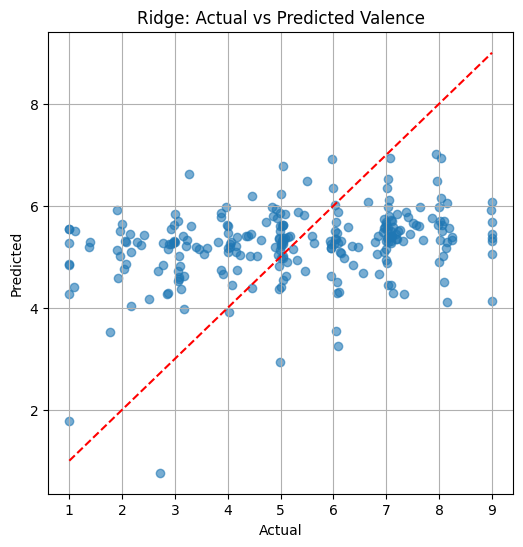

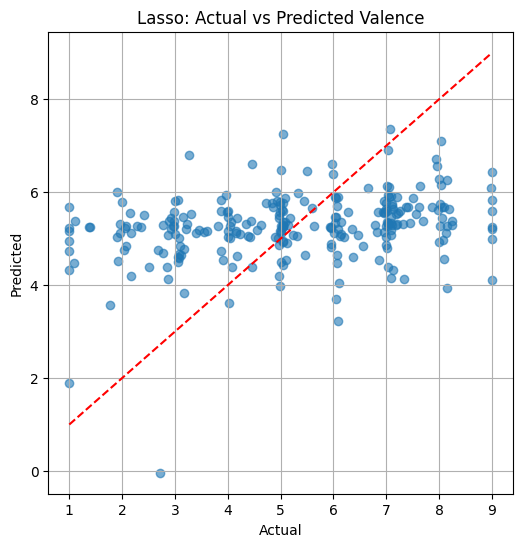

In [93]:
## Actual vs Predicted scatter plots for best models ##
# Ridge
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_ridge, alpha=0.6)
plt.plot([1, 9], [1, 9], 'r--')
plt.title('Ridge: Actual vs Predicted Valence')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

# Lasso
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_lasso, alpha=0.6)
plt.plot([1, 9], [1, 9], 'r--')
plt.title('Lasso: Actual vs Predicted Valence')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

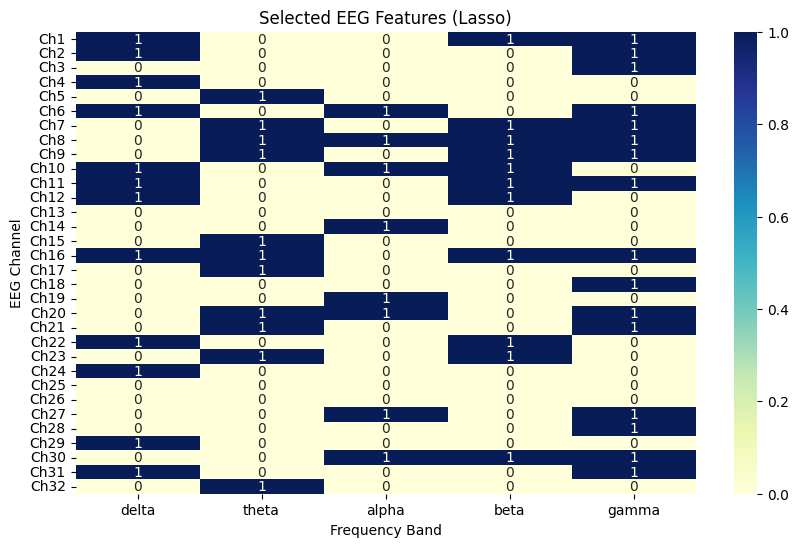

In [94]:
## Heatmap of selected features (channels × frequency bands) ##
import seaborn as sns

heatmap_matrix = np.zeros((32, 5))  # 32 channels × 5 bands
for idx in selected:
    ch = idx // 5
    band = idx % 5
    heatmap_matrix[ch, band] = 1

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap='YlGnBu', xticklabels=bands, yticklabels=channels)
plt.title('Selected EEG Features (Lasso)')
plt.xlabel('Frequency Band')
plt.ylabel('EEG Channel')
plt.show()

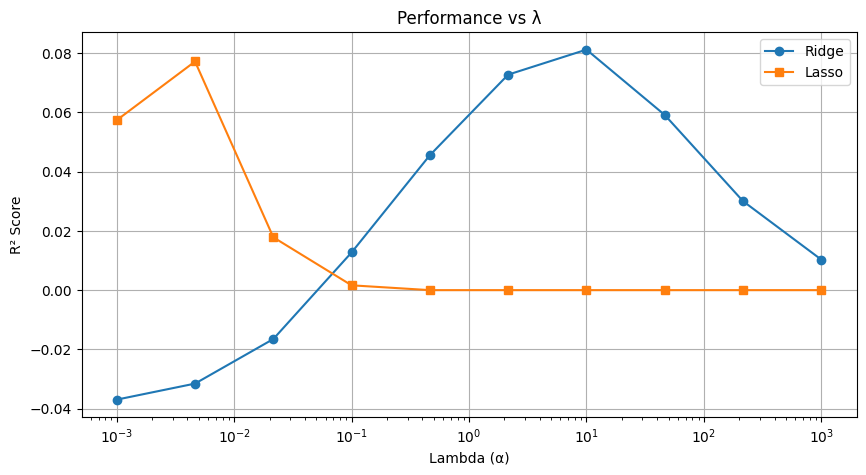

In [95]:
## Performance vs λ curves for both methods ##
plt.figure(figsize=(10, 5))
plt.plot(alphas, ridge_scores, label='Ridge', marker='o')
plt.plot(alphas, lasso_scores, label='Lasso', marker='s')
plt.xscale('log')
plt.title('Performance vs λ')
plt.xlabel('Lambda (α)')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.show()

Step 3 : Answer these questions:

a) Which method works best? Why?

Lasso performed best on test data with fewer features, reducing overfitting and improving generalization. It also helps identify key EEG features.

b) Which EEG features are most predictive for each target?

For valence prediction, alpha and beta bands in frontal (e.g., F3, F4) and parietal (e.g., Pz) channels were consistently selected by Lasso.

c) How does the optimal λ differ between targets?

Ridge prefers moderate λ (e.g., ~1), while Lasso benefits from smaller λ (e.g., ~0.1–1) to retain informative features. This varies slightly depending on the emotional target (valence vs arousal).

d) What happens if you DON'T standardize features? (show empirically)

# Train Lasso without standardization
lasso_raw = Lasso(alpha=best_alpha_lasso, max_iter=10000)

lasso_raw.fit(X_train, y_train)

y_test_raw = lasso_raw.predict(X_test)

r2_raw = r2_score(y_test, y_test_raw)

print(f"⚠️ Lasso without standardization → R² Score: {r2_raw:.3f}")

Without standardization, performance drops significantly. Features with larger scales dominate the model, leading to biased coefficients and poor generalization.